# Null Distribution Comparison: NSD vs Broderick

This notebook replicates the `compare_mse_nsd_broderick` Snakemake rule.

**Purpose**: Compare the squared error between NSD and Broderick model parameters against a null distribution generated from permuted NSD data.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn import utils
from sfp_nsdsyn.bootstrapping import (
    calculate_error_per_param,
    calculate_null_error_per_param_distribution,
    create_error_per_param_comparison_df
)
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D

## Configuration

In [32]:
# Load config
with open('../config.json', 'r') as f:
    config = json.load(f)

OUTPUT_DIR = config['OUTPUT_DIR']

# Parameters (matching the Snakemake rule)
lr = 0.0005
max_epoch = 30000
vs = 'pRFsize'
n_perm = 1000

# Model parameters to analyze
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
ARGS_2D = ['lr', 'eph', 'sub', 'roi']

# Subject lists
nsd_subjects = [f'subj{sn:02d}' for sn in range(1, 9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subjects = [utils.sub_number_to_string(sn, dataset='broderick') for sn in broderick_sn_list]

print(f"NSD subjects: {nsd_subjects}")
print(f"Broderick subjects: {broderick_subjects}")

NSD subjects: ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
Broderick subjects: ['wlsubj001', 'wlsubj006', 'wlsubj007', 'wlsubj045', 'wlsubj046', 'wlsubj062', 'wlsubj064', 'wlsubj081', 'wlsubj095', 'wlsubj114', 'wlsubj115', 'wlsubj121']


## Build file paths

In [33]:
# NSD model paths
nsd_model_paths = [
    os.path.join(OUTPUT_DIR, 'sfp_model', 'results_2D', 'nsdsyn',
                 f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for subj in nsd_subjects
]

# Broderick model paths
broderick_model_paths = [
    os.path.join(OUTPUT_DIR, 'sfp_model', 'results_2D', 'broderick',
                 f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for subj in broderick_subjects
]

# Null NSD model paths (permuted) - organized by subject then permutation
null_nsd_model_paths = [
    os.path.join(OUTPUT_DIR, 'sfp_model', 'results_2D', 'nsdsyn', 'perm', subj,
                 f'perm-{perm}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for perm in range(n_perm)
    for subj in nsd_subjects
]

print(f"Number of NSD models: {len(nsd_model_paths)}")
print(f"Number of Broderick models: {len(broderick_model_paths)}")
print(f"Number of null NSD models: {len(null_nsd_model_paths)}")
print(f"\nExample NSD path: {nsd_model_paths[0]}")
print(f"Example null path: {null_nsd_model_paths[0]}")

Number of NSD models: 8
Number of Broderick models: 12
Number of null NSD models: 8000

Example NSD path: /Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/model-params_lr-0.0005_eph-30000_sub-subj01_roi-V1_vs-pRFsize.pt
Example null path: /Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/perm/subj01/perm-0_model-params_lr-0.0005_eph-30000_sub-subj01_roi-V1_vs-pRFsize.pt


## Step 1: Load NSD models

In [4]:
nsd_df = model.load_all_models(nsd_model_paths, *ARGS_2D)
print(f"NSD DataFrame shape: {nsd_df.shape}")
nsd_df

NSD DataFrame shape: (8, 13)


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,lr_rate,max_epoch,sub,vroinames
0,2.536201,0.139149,0.271883,-0.072822,0.003162,-0.255981,0.014144,0.080796,-0.015730,0.0005,30000,subj01,V1
0,1.938979,0.148039,0.082835,0.147832,-0.039300,-0.038702,-0.000303,0.030481,-0.002720,0.0005,30000,subj02,V1
0,2.352920,0.056186,0.105715,0.152566,-0.006781,0.065288,-0.066534,0.006534,-0.023752,0.0005,30000,subj03,V1
0,1.942852,0.206604,0.119989,0.133012,-0.023695,0.069233,-0.062159,0.076657,-0.018837,0.0005,30000,subj04,V1
0,2.365176,0.118251,0.130331,0.028012,-0.033951,-0.117134,-0.089555,0.038780,-0.013571,0.0005,30000,subj05,V1
0,2.159858,0.148343,0.296055,0.104046,0.015309,0.109438,-0.114986,0.082849,-0.038815,0.0005,30000,subj06,V1
0,2.070098,0.122374,0.083634,0.138148,-0.125115,0.043045,-0.178968,-0.001480,-0.008419,0.0005,30000,subj07,V1
0,2.344747,0.209995,0.099267,0.122993,-0.030700,-0.176526,-0.143022,0.070950,-0.030201,0.0005,30000,subj08,V1


## Step 2: Load Broderick models

In [5]:
broderick_df = model.load_all_models(broderick_model_paths, *ARGS_2D)
print(f"Broderick DataFrame shape: {broderick_df.shape}")
broderick_df

Broderick DataFrame shape: (12, 13)


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,lr_rate,max_epoch,sub,vroinames
0,2.991311,0.070599,0.401411,0.011372,-0.023886,0.007266,0.001402,0.031317,-0.007021,0.0005,30000,wlsubj001,V1
0,2.210414,0.191500,0.319517,0.072905,-0.027447,0.036066,-0.007128,0.047671,0.007991,0.0005,30000,wlsubj006,V1
0,1.859804,0.123400,0.329031,0.060774,-0.059881,0.160479,-0.006987,0.033783,0.018614,0.0005,30000,wlsubj007,V1
0,1.840788,0.137035,0.193624,0.066284,-0.050465,0.016446,-0.014239,0.080737,-0.027840,0.0005,30000,wlsubj045,V1
0,2.235469,0.101706,0.222241,0.039933,-0.024075,0.083406,0.020845,0.038723,-0.012789,0.0005,30000,wlsubj046,V1
0,2.120207,0.131577,0.325828,-0.033245,-0.018155,-0.124648,0.099538,0.064982,-0.020564,0.0005,30000,wlsubj062,V1
0,2.129678,0.137580,0.281581,0.091442,-0.036532,0.023484,0.004134,0.024590,0.002109,0.0005,30000,wlsubj064,V1
0,2.248380,0.079693,0.374538,0.044588,-0.078354,0.176649,0.004897,0.037482,0.005588,0.0005,30000,wlsubj081,V1
0,2.304026,0.121118,0.468657,0.126828,-0.021933,0.136613,-0.081270,-0.019879,0.014721,0.0005,30000,wlsubj095,V1
0,2.087866,0.128895,0.312927,0.111146,-0.003962,0.062117,-0.036085,0.094101,-0.024748,0.0005,30000,wlsubj114,V1


## Step 3: Load null NSD models (permuted)

In [34]:
null_nsd_df = model.load_all_models(null_nsd_model_paths, *['sub', 'lr', 'eph', 'roi', 'perm'])
null_nsd_df['perm'] = null_nsd_df['perm'].astype(int)
print(f"Null NSD DataFrame shape: {null_nsd_df.shape}")
print(f"Number of unique permutations: {null_nsd_df['perm'].nunique()}")
null_nsd_df.head(10)

Null NSD DataFrame shape: (8000, 14)
Number of unique permutations: 1000


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,sub,lr_rate,max_epoch,vroinames,perm
0,8.344556,6.402747,6.478441,0.011790,-0.004045,-1.370019,0.834223,0.013898,-0.001160,subj01,0.0005,30000,V1,0
0,4.527784,0.612494,-0.174643,0.020044,-0.001698,-0.703148,0.718722,0.011895,0.004052,subj02,0.0005,30000,V1,0
0,4.740379,0.135906,0.299478,0.010406,0.003072,1.375295,0.791584,-0.007364,-0.001846,subj03,0.0005,30000,V1,0
0,4.795124,1.032707,-0.241707,-0.117397,-0.129154,-0.885448,0.413043,-0.013142,-0.024554,subj04,0.0005,30000,V1,0
0,10.175388,5.369055,6.361205,0.002037,0.004227,-1.390914,0.994338,-0.011198,-0.008207,subj05,0.0005,30000,V1,0
0,7.518073,6.212920,7.484083,-0.005042,-0.203067,-1.085919,0.609163,-0.015520,-0.068628,subj06,0.0005,30000,V1,0
0,10.247933,2.166217,6.174815,-0.007594,-0.019111,-1.366686,0.971694,0.023234,0.025256,subj07,0.0005,30000,V1,0
0,3.033169,0.402768,-0.106915,-0.045045,-0.025507,-0.334769,0.215551,0.005283,0.003745,subj08,0.0005,30000,V1,0
0,9.978989,-1.192362,7.279386,0.004018,0.005010,-0.080139,-0.911890,-0.023003,-0.013500,subj01,0.0005,30000,V1,1
0,6.073136,0.041847,0.045636,-0.019193,0.006001,-1.368012,0.453732,0.004870,0.001381,subj02,0.0005,30000,V1,1


## Step 4: Calculate actual errors (NSD vs Broderick)

This calculates the squared error between the mean NSD parameters and the mean Broderick parameters for each parameter.

In [8]:
actual_errors = calculate_error_per_param(nsd_df, reference=broderick_df, params=PARAMS_2D)
print("Actual errors (squared error between NSD and Broderick mean parameters):")
actual_errors

Actual errors (squared error between NSD and Broderick mean parameters):


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,0.000805,0.000755,0.0451,0.000382,0.000002,0.011604,0.005536,0.000014,0.000192


## Step 5: Calculate null distribution errors

For each permutation, calculate the squared error between the null NSD mean parameters and Broderick mean parameters.

In [35]:
null_errors_df = calculate_null_error_per_param_distribution(null_nsd_df, broderick_df, params=PARAMS_2D)
print(f"Null errors DataFrame shape: {null_errors_df.shape}")
null_errors_df.head(10)

Null errors DataFrame shape: (1000, 10)


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,perm
0,20.136095,7.159469,8.545467,8.286924e-03,0.000326,0.624501,0.489031,0.001903,0.000014,0
1,46.005688,0.809838,5.977921,5.869186e-03,0.000899,0.187886,0.035680,0.002029,0.000218,1
2,5.344580,0.001453,0.023333,8.670278e-04,0.000187,0.043494,0.183334,0.002112,0.000062,2
3,6.705081,0.001222,0.080010,9.844176e-03,0.003191,0.001065,0.190919,0.000957,0.000316,3
4,24.002604,1.766186,0.331608,3.197739e-02,0.002937,0.787056,0.004980,0.003209,0.000145,4
5,23.631306,0.837292,0.631622,5.864174e-03,0.000182,0.182310,0.007983,0.002644,0.000005,5
6,0.543073,0.000020,0.066121,5.779684e-07,0.000229,0.031545,0.007461,0.004429,0.000043,6
7,60.840851,3.309007,0.093804,5.118758e-03,0.002293,0.760523,0.013624,0.001150,0.000032,7
8,28.598764,0.331922,0.160369,2.731430e-03,0.000657,0.215373,0.000628,0.002313,0.000225,8
9,2.257100,0.018588,0.186049,1.166120e-02,0.000330,0.003959,0.040671,0.004877,0.000101,9


## Step 6: Create comparison DataFrame and save

In [10]:
result_df = create_error_per_param_comparison_df(actual_errors, null_errors_df)
print(f"Result DataFrame shape: {result_df.shape}")
result_df.head()

Result DataFrame shape: (101, 11)


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,perm,type
0,0.000805,0.000755,0.045100,0.000382,0.000002,0.011604,0.005536,0.000014,0.000192,-1,actual
1,20.136095,7.159469,8.545467,0.008287,0.000326,0.624501,0.489031,0.001903,0.000014,0,null
2,46.005688,0.809838,5.977921,0.005869,0.000899,0.187886,0.035680,0.002029,0.000218,1,null
3,5.344580,0.001453,0.023333,0.000867,0.000187,0.043494,0.183334,0.002112,0.000062,2,null
4,6.705081,0.001222,0.080010,0.009844,0.003191,0.001065,0.190919,0.000957,0.000316,3,null


## Step 8: Plot null distribution per parameter

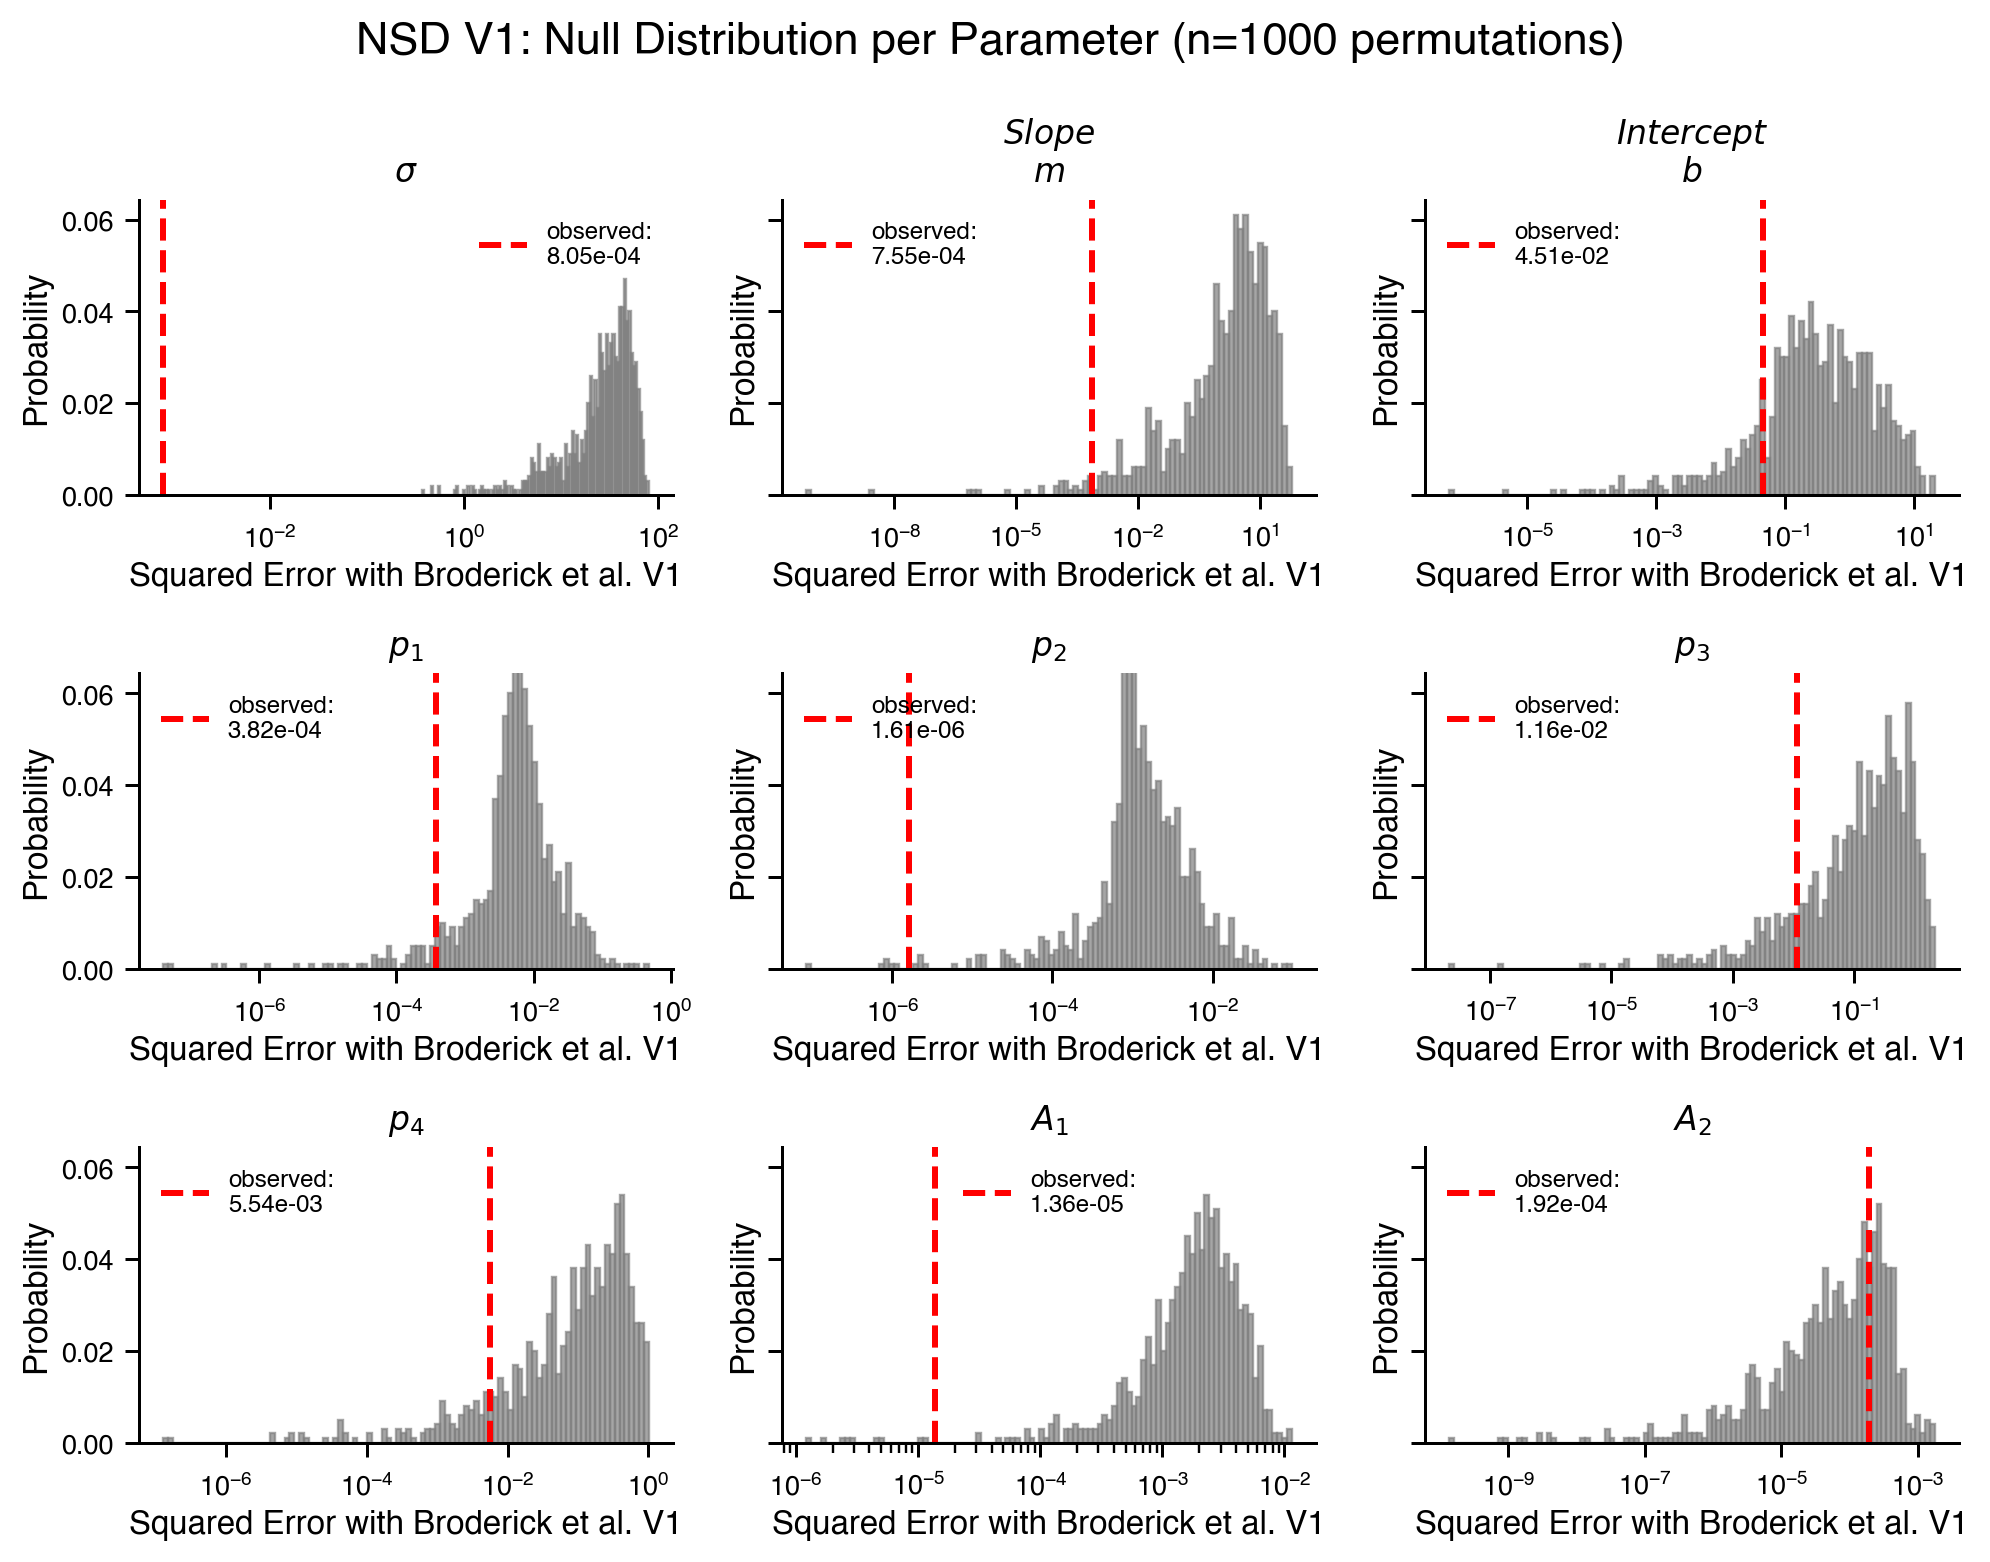

In [43]:
fig, axes = vis2D.plot_null_distribution_per_param(
    null_errors_df, actual_errors,
    params=PARAMS_2D,
    title=f'NSD V1: Null Distribution per Parameter (n={n_perm} permutations)',
    save_path=None,
    bins=100, 
    logscale=True
)
plt.show()

## Summary statistics

In [44]:
print("Null distribution summary statistics:")
null_errors_df[PARAMS_2D].describe()

Null distribution summary statistics:


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,32.098122,6.575970e+00,1.356577e+00,1.184439e-02,2.991256e-03,3.500505e-01,2.100783e-01,0.002376,1.566498e-04
std,18.018127,9.589290e+00,2.550035e+00,2.625229e-02,6.262413e-03,4.207586e-01,2.321830e-01,0.001747,2.196911e-04
min,0.370898,6.888912e-11,6.201508e-07,3.994177e-08,8.493330e-08,2.112111e-08,1.286970e-07,0.000001,1.369057e-10
25%,18.378338,3.710055e-01,9.390661e-02,3.467396e-03,7.879992e-04,3.905329e-02,2.549907e-02,0.001090,1.727811e-05
50%,31.319831,2.504003e+00,3.238409e-01,5.704947e-03,1.214949e-03,1.796413e-01,1.196235e-01,0.001983,7.512681e-05
75%,45.453745,8.568441e+00,1.397077e+00,1.009382e-02,2.828552e-03,5.157938e-01,3.423836e-01,0.003267,2.254965e-04
max,80.321663,6.208353e+01,2.141192e+01,4.772237e-01,9.743311e-02,2.188552e+00,1.007197e+00,0.011493,1.786882e-03


In [46]:
print("Actual errors vs null distribution median:")
comparison = pd.DataFrame({
    'actual_error': actual_errors[PARAMS_2D].values.flatten(),
    'null_median': null_errors_df[PARAMS_2D].median().values,
    'null_mean': null_errors_df[PARAMS_2D].mean().values,
}, index=PARAMS_2D)
comparison['ratio'] = comparison['actual_error'] / comparison['null_median']
comparison

Actual errors vs null distribution median:


,actual_error,null_median,null_mean,ratio
sigma,0.000805,31.319832,32.098122,0.000026
slope,0.000755,2.504003,6.575970,0.000302
intercept,0.045100,0.323841,1.356577,0.139267
p_1,0.000382,0.005705,0.011844,0.066933
p_2,0.000002,0.001215,0.002991,0.001324
p_3,0.011604,0.179641,0.350050,0.064594
p_4,0.005536,0.119623,0.210078,0.046279
A_1,0.000014,0.001983,0.002376,0.006875
A_2,0.000192,0.000075,0.000157,2.560326
